# Workshop on integrated hydrological/hydraulic modelling


## Objectives

To apply uncertainty analysis to a hydrological model using Python.

After this workshop, you are able to
- read, analyse and visualize the simulation results
- sample the model parameters from given distribution
- connect hydrological models with hydraulic model in an integrated modelling system
- interpret and communicate the results

## Sugawara

The Sugawara (Sugawara 1961) tank is an extension of the Linear Reservoir model which uses several (linear or non-linear) tanks. The flexibility in the selection of the number of tanks, and its response, provides a more complex representation of the phenomena, which not necessarily yields better simulation results. A 2 linear tanks Sugawara model is presented in Figure 4, however the configuration of the tanks is arbitrary and has to be defined by the modeller.

<img src='Figures/Sugawara1.png' width="400"></img>

Where P stands for precipitation and ET for evapotranspiration. S1 and S2 are the model states, represented by the water level in each of the tanks. d1 and d2 are the position of the outlets in the top tank. And k1to k4 represent the flux constants. Therefore, d and k are the model parameters to be determine during calibration. The description of the model components is presented in Table 1.

<img src='Figures/Sugawara2.png' width="400"></img>

Then we start importing all libraries including the file `sugawara.py`

In [2]:
# Here we import all the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
# import seaborn as sns

import sugawara

## Reading an output data file (Learning data frames)

In this example we are going to read a file which contains the modelling results of a hydrological model. 

In [3]:
### Read the output.asc file
skip_rows = 16  # Number of rows to skip in the output file
output_file = 'output.asc' # Name of the output file

# Read data from the output file
data = pd.read_csv(output_file,
                   skiprows=skip_rows,
                   skipinitialspace=True,
                   index_col='Time')

# Create vector with time stamps
time_index = pd.date_range('1994 12 07 20:00', periods=len(data), freq='H')

# Add time stamps to observations
data.set_index(time_index, inplace=True)

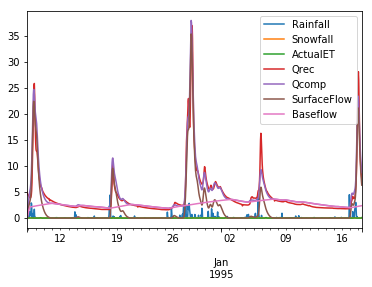

In [4]:
# Plot the complete dataframe
data.plot()
plt.show()

In [5]:
#Exploring your data
data.head()       # first five rows of the dataset

,Rainfall,Snowfall,ActualET,Qrec,Qcomp,SurfaceFlow,Baseflow
1994-12-07 20:00:00,0.000,0.0,0.0161,5.0128,0.10403,0.06684,0.03718
1994-12-07 21:00:00,0.000,0.0,0.0015,4.7944,0.40941,0.26045,0.14896
1994-12-07 22:00:00,0.000,0.0,0.0098,4.6394,0.90345,0.56768,0.33577
1994-12-07 23:00:00,0.006,0.0,0.0238,4.5134,1.57489,0.97685,0.59804
1994-12-08 00:00:00,0.288,0.0,0.0332,4.3801,2.42031,1.48408,0.93623


In [6]:
data.tail()       # last five rows of the dataset

,Rainfall,Snowfall,ActualET,Qrec,Qcomp,SurfaceFlow,Baseflow
1995-01-18 07:00:00,0.0,0.0,0.0022,10.9651,12.59091,10.24821,2.34270
1995-01-18 08:00:00,0.0,0.0,0.0000,9.7348,11.39572,9.04161,2.35411
1995-01-18 09:00:00,0.0,0.0,0.0000,8.8476,10.37150,8.00602,2.36547
1995-01-18 10:00:00,0.0,0.0,0.0445,8.1579,9.48687,7.11007,2.37680
1995-01-18 11:00:00,0.0,0.0,0.0985,7.6158,8.71734,6.32926,2.38808


In [7]:
n = 10
data.sample(n)    # random n sample of rows from the dataset

,Rainfall,Snowfall,ActualET,Qrec,Qcomp,SurfaceFlow,Baseflow
1994-12-25 01:00:00,0.021,0.0,0.0000,1.6092,1.92076,0.00000,1.92076
1994-12-28 00:00:00,2.837,0.0,0.0053,19.1160,20.58200,18.05400,2.52800
1994-12-26 00:00:00,0.000,0.0,0.0000,2.1204,2.33408,0.29899,2.03509
1994-12-08 08:00:00,1.228,0.0,0.0173,4.0970,7.15258,4.98185,2.17072
1995-01-17 06:00:00,0.001,0.0,0.0000,3.5019,4.77008,2.72664,2.04344
1994-12-18 17:00:00,0.018,0.0,0.0000,6.1625,8.60081,6.54711,2.05370
1994-12-27 07:00:00,1.930,0.0,0.0086,2.5190,2.40700,0.05426,2.35274
1994-12-12 09:00:00,0.000,0.0,0.0159,2.4500,2.53873,0.00000,2.53873
1994-12-27 00:00:00,0.023,0.0,0.0329,2.4611,2.31542,0.00216,2.31326
1994-12-14 10:00:00,0.004,0.0,0.0248,2.2698,2.46367,0.09777,2.36590


In [8]:
data.describe()   # calculate some general statistical indicators

,Rainfall,Snowfall,ActualET,Qrec,Qcomp,SurfaceFlow,Baseflow
count,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.134195,0.0,0.015314,4.271259,4.538186,1.896508,2.641678
std,0.449278,0.0,0.019911,4.554723,4.735063,4.747417,0.535702
min,0.000000,0.0,0.000000,1.594800,0.104030,0.000000,0.037180
25%,0.000000,0.0,0.000000,2.015550,2.347235,0.000000,2.230002
50%,0.004000,0.0,0.008850,2.698000,3.009970,0.000845,2.515795
75%,0.027000,0.0,0.023500,4.200900,4.127172,1.356777,3.119040
max,4.490000,0.0,0.115000,36.943400,37.927100,35.335320,3.649640


In [9]:
data.info()       # memory footprint and datatypes

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 1994-12-07 20:00:00 to 1995-01-18 11:00:00
Freq: H
Data columns (total 7 columns):
Rainfall       1000 non-null float64
Snowfall       1000 non-null float64
ActualET       1000 non-null float64
Qrec           1000 non-null float64
Qcomp          1000 non-null float64
SurfaceFlow    1000 non-null float64
Baseflow       1000 non-null float64
dtypes: float64(7)
memory usage: 62.5 KB


In [10]:
#Accesing one sample using indices
print(data.iloc[0, 3])  # sample 1 at time 1 (first value is the index (in this case we said time) the second is the column name

5.0128


In [11]:
print(data.iloc[0:5, 3])  # sample of a fraction of the discharge time series 


1994-12-07 20:00:00    5.0128
1994-12-07 21:00:00    4.7944
1994-12-07 22:00:00    4.6394
1994-12-07 23:00:00    4.5134
1994-12-08 00:00:00    4.3801
Freq: H, Name: Qrec, dtype: float64


In [12]:
print(data['Qrec'][:3])

1994-12-07 20:00:00    5.0128
1994-12-07 21:00:00    4.7944
1994-12-07 22:00:00    4.6394
Freq: H, Name: Qrec, dtype: float64


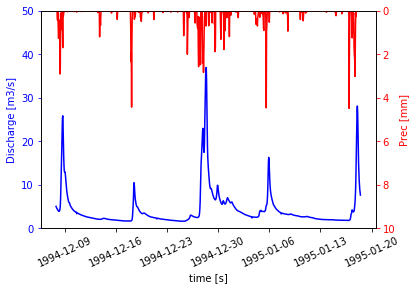

In [13]:
# Make a precipitation-dischage plot

# initialise the canvas
fig, ax1 = plt.subplots()

# Make the plot of the precipitaiton dataset
ax1.plot(data['Qrec'], 'b')
ax1.set_xlabel('time [s]')

# Rotate the xticks
plt.xticks(rotation=25)

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Discharge [m3/s]', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim([0, 50])

# Make the secondary axis and plot in it
ax2 = ax1.twinx()
ax2.plot(data['Rainfall'], 'r')

# Change the colors to match the secondary axis
ax2.set_ylabel('Prec [mm]', color='r')
ax2.tick_params('y', colors='r')

# Invert the axis by switching the limits
ax2.set_ylim([10, 0])

# display the plot
plt.show()

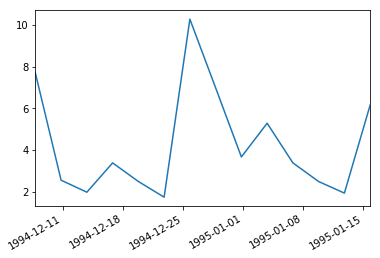

In [14]:
data['Qrec'].resample('3D').mean().plot()
plt.show()

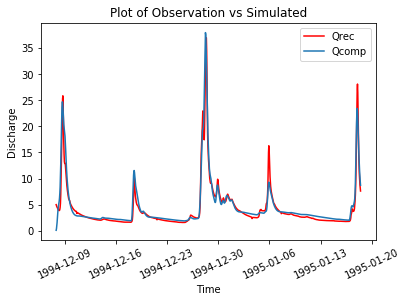

In [15]:
# Make a simulated-recorded discharge plot

observ = data.Qrec;   # Extract the observation
output = data.Qcomp;   # Extract the simulation

plt.plot(observ,'r')           # Plot the observation
plt.plot(output)               # Plot the simulation
plt.xlabel('Time')
plt.ylabel('Discharge')
plt.xticks(rotation=25)
plt.legend()
plt.title('Plot of Observation vs Simulated')
plt.show()

# Hydrological and hydraulic modelling

As we have already discussed, hydrological models describe the movement of water over the land, where is conveyed to a river. This river routes the water downstream, to a larger water body, and eventually to the sea. The movement of water in the river does not have the same properties as in a canal, and therefore, it is necessary to have a different type of model to represent this movement.

Hydraulic models, and especially 1D models simulate the movement of water in open canals by using the Saint-Venant equations. To solve the Saint-Venant equations, is required to have 2 boundary conditions, which should be either discharge or depth, and should be located upstream and downstream.

Hydrological models usually provide estimations of discharge at the concentration point of a (sub)catchment. This information is usually used as upstream boundary condition for the hydraulic models, while the downstream condition will depend on what are the characteristics of the particular case. For example, the sea is a good example of a downstream boundary condition where depth is provided.

Now, the task at this moment consists in connecting hydrological and hydraulic models, to understand the movement of water, and therefore, provide data for simulation and decision making regarding the availablity of water. These decisions may include: water allocation, flood forecasting, etc.

Use the data for the Brue catchment, as upstream boundary condition, and define a hydraulic model using the code for FSF to route the hydrograph downstream to the end. This case is purely hypothetical, but it will help you understand a complete water modelling system.


In [16]:
# Run the hydrological model and get the discharge hydrograph

# Define the characteristics and parameters of your (simplified) hydraulic model

# Use the results of the hydrological model as boundary conditions of the hydraulic model

# run the hydraulic model

# Evaluate the results and draw conclusions